# p2 - Underground Commuters 


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#we are going to read the tube network from the shape file
#first, check current directory
os.getcwd()

'/Users/yingchen/Documents2/CASA/urban_simulation/practical/wk7/Week_7_final'

In [3]:
# You need to set the working directory to where you have your shapefile data
os.chdir('underground')

# Let's create a graph from the shapefile
g_shp=nx.read_shp('underground.shp',geom_attrs=False)

In [4]:
#we will need to add station names as attributes of the nodes:
nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}
#nod_all = {**nod_st1, **nod_st2} #for python 3.5 and greater

#In Python 2, (or 3.4 or lower) write a function
nod_all = nod_st1.copy()   # start with x's keys and values
nod_all.update(nod_st2)

nx.set_node_attributes(g_shp,nod_all,'station')

# get the nodes attributes:
#list(g_shp.nodes(data=True))[0:10]

In [5]:
#do we want this graph to be a directed one? In fact, only a few links in the dataset are directed

# We can transform the type of graph from directed to undirected using the following function:
g_shp_un = g_shp.to_undirected()

#Finally, we will give an ID to each node(station), such that it will be easier later to call them:
#1.Create a new attribute with node coordinates (now coord are the keys and we do not want to lose that information
nod_coord = {(e1):e1 for e1 in g_shp_un.nodes()}
nx.set_node_attributes(g_shp_un,nod_coord,'station_coord')
list(g_shp_un.nodes(data=True))[0]


((-0.1571, 51.5226),
 {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)})

In [6]:
#2.now relabel each node with an ordered integer:
node_list = list(g_shp_un.nodes())
mapping = {node_list[i]:i for i in range(len(node_list))}
g_shp_un = nx.relabel_nodes(g_shp_un, mapping)
list(g_shp_un.nodes(data=True))[0]

(0, {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)})

In [7]:
#Later when using the Commuters data we will have an issue mapping node 'Heathrow Terminals 1, 2 & 3', 
#so we are going to rename it here:
#1. find the node 'Heathrow Terminals 1, 2 & 3'
nodes = [(x,y) for x,y in g_shp_un.nodes(data='station') if 'Heathrow' in str(y)]
nodes

[(258, 'Heathrow Terminals 1, 2 & 3'), (259, 'Heathrow Terminal 4')]

In [8]:
#2.Rename it with the name given by the the commuters file (see later):
g_shp_un.nodes[258]['station']='Heathrow Terminals 123'

## Commuters flows in the tube network

We are going to create the flows of commuters travelling between any pair of tube stations

In [9]:
import pandas as pd
#First, we read the csv file with commuting flows starting and ending between stations, called Origin-Destination:
#Check you are in the correct directory to read the csv 
os.getcwd()

'/Users/yingchen/Documents2/CASA/urban_simulation/practical/wk7/Week_7_final/underground'

In [10]:
os.chdir('..')
os.getcwd()

'/Users/yingchen/Documents2/CASA/urban_simulation/practical/wk7/Week_7_final'

In [11]:
# Read Origin-Destination table from the csv
orig_dest = pd.read_csv('ODtube2017.csv')
orig_dest.head()

,From,station_name,To,station_name.1,total_wtrips
0,500,Acton Town,505,Alperton,143
1,500,Acton Town,506,Amersham,22
2,500,Acton Town,507,Angel,15
3,500,Acton Town,508,Archway,9
4,500,Acton Town,510,Arsenal,9


In [12]:
#This can be seen as a network by itself:
g_OD = nx.from_pandas_edgelist(orig_dest, 'station_name', 'station_name.1',['total_wtrips'],create_using=nx.MultiDiGraph)

In [13]:
#Change the names of nodes by the id in g_shp_un (tube network):

#1.Copy name as an attribute:
nod_names={(e1):e1 for e1 in g_OD.nodes()}
nx.set_node_attributes(g_OD,nod_names,'station') #with nod_id1 or nod_id2 is enought
print(list(g_OD.nodes(data=True))[:10])

[('Acton Town', {'station': 'Acton Town'}), ('Alperton', {'station': 'Alperton'}), ('Amersham', {'station': 'Amersham'}), ('Angel', {'station': 'Angel'}), ('Archway', {'station': 'Archway'}), ('Arsenal', {'station': 'Arsenal'}), ('Baker Street', {'station': 'Baker Street'}), ('Bank', {'station': 'Bank'}), ('Barbican', {'station': 'Barbican'}), ('Barons Court', {'station': 'Barons Court'})]


In [14]:
#2.Do the mapping with id in g_shp_un
mapping = {g_shp_un.nodes[i]['station']:i for i in g_shp_un.nodes()}
g_OD = nx.relabel_nodes(g_OD, mapping)
print(list(g_OD.nodes(data=True))[:10])

[(111, {'station': 'Acton Town'}), (238, {'station': 'Alperton'}), (172, {'station': 'Amersham'}), (196, {'station': 'Angel'}), (198, {'station': 'Archway'}), (244, {'station': 'Arsenal'}), (0, {'station': 'Baker Street'}), (25, {'station': 'Bank'}), (77, {'station': 'Barbican'}), (100, {'station': 'Barons Court'})]


In [15]:
#and we can add coordinates to the nodes, from the shapefile of the tube network:
nod_coords={(e1):coord for e1, coord in g_shp_un.nodes(data='station_coord')}

nx.set_node_attributes(g_OD,nod_coords,'station_coord') #with nod_id1 or nod_id2 is enought

pos = {e1: xy for e1,xy in g_OD.nodes(data='station_coord')}


In [16]:
#Even if we have not considered the weights (we will later on), 
#this network does not represent the commuting flows, what is happening?

#From the Origin Destination network, we need to compute the number of commuters for each pair of stations:
#How will we know the path of commuters from their origin to their destinations? 
#Given that the tube network is undirected and that we do not have information on the different tube lines, 
#we will assume that commuters use the shortest path between Origin and Destination

In [17]:
#Now, let's create the network with the actual flow of commuters travelling between each pair of stations,
#regardless which was their origin and destination:

#We will create that graph using the adjacency matrix method that was presented in previous practicals:
#First we create an empty adjacency matrix:
N=len(g_shp_un.nodes()) #As we are going to use shortest path in the tube network, N is from g_shp_un
adj_c=np.zeros((N, N))

#Fill the adjacency matrix with Origin-Destination flows:
#From origin to destination with x commuters, we will compute the shortest path and fill the number of commuters
#for each pair of stations they go through:
for e1,e2,C in g_OD.edges(data='total_wtrips'):
    path = nx.dijkstra_path(g_shp_un,e1,e2,'distance')  #shortest path e1,e2 taking into account distance weights in g_shp_un
    path_edges = list(zip(path,path[1:])) #list of tuples with shortest path edges [(e1,s2),(s3,s4),...,(s(n-1),e2)]
    for (s1,s2) in path_edges:
            adj_c[s1,s2]=adj_c[s1,s2]+C #sum the contribution of the OD flow to all edges in the shortest path
adj_c

array([[     0.,  96682.,   1560., ...,      0.,      0.,      0.],
       [102485.,      0.,      0., ...,      0.,      0.,      0.],
       [  1167.,      0.,      0., ...,      0.,      0.,      0.],
       ...,
       [     0.,      0.,      0., ...,      0.,  34817.,      0.],
       [     0.,      0.,      0., ...,  37111.,      0.,      0.],
       [     0.,      0.,      0., ...,      0.,      0.,      0.]])

In [18]:
#Create the new graph from the adjancency matrix:
g_flows=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph)


In [19]:
#we need to give coordinates to these nodes too:
nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(g_flows,nod_coord,'station_coord')
list(g_flows.nodes(data=True))[0:10]

[(0, {'station_coord': (-0.1571, 51.5226)}),
 (1, {'station_coord': (-0.1631, 51.5225)}),
 (2, {'station_coord': (-0.1466, 51.5234)}),
 (3, {'station_coord': (-0.1247, 51.508)}),
 (4, {'station_coord': (-0.1223, 51.5074)}),
 (5, {'station_coord': (-0.1342, 51.5098)}),
 (6, {'station_coord': (-0.1679, 51.5199)}),
 (7, {'station_coord': (-0.1755, 51.5154)}),
 (8, {'station_coord': (-0.1001, 51.4943)}),
 (9, {'station_coord': (-0.1115, 51.4991)})]

In [20]:
#also the station names:
nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(g_flows,nod_names,'station')
list(g_flows.nodes(data=True))[0:10]

[(0, {'station_coord': (-0.1571, 51.5226), 'station': 'Baker Street'}),
 (1, {'station_coord': (-0.1631, 51.5225), 'station': 'Marylebone'}),
 (2, {'station_coord': (-0.1466, 51.5234), 'station': "Regent's Park"}),
 (3, {'station_coord': (-0.1247, 51.508), 'station': 'Charing Cross'}),
 (4, {'station_coord': (-0.1223, 51.5074), 'station': 'Embankment'}),
 (5, {'station_coord': (-0.1342, 51.5098), 'station': 'Picadilly Circus'}),
 (6, {'station_coord': (-0.1679, 51.5199), 'station': 'Edgware Road (B)'}),
 (7, {'station_coord': (-0.1755, 51.5154), 'station': 'Paddington'}),
 (8, {'station_coord': (-0.1001, 51.4943), 'station': 'Elephant & Castle'}),
 (9, {'station_coord': (-0.1115, 51.4991), 'station': 'Lambeth North'})]

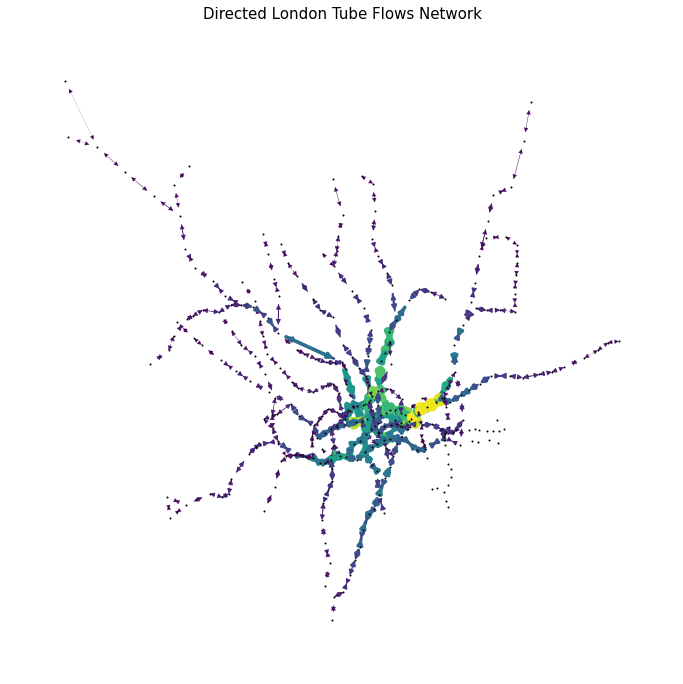

In [21]:
# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in g_flows.edges(data='weight')]

weights_color=[(w/max(weights)) for e1,e2,w in g_flows.edges(data='weight')]
weights_size=[(w/max(weights)*10) for e1,e2,w in g_flows.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(g_flows, pos,edge_color=weights_color, width=weights_size)

nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.axis("off")
plt.title("Directed London Tube Flows Network",fontsize=15)
plt.show()

#this are the directed flows in the tube network!

### Search from node/edge

In [22]:
#We can search for nodes in the flow network
#node
node = [(x,y) for x,y in g_flows.nodes(data='station') if y=='Kilburn']
node

[(168, 'Kilburn')]

In [23]:
#or if you do not know how exacly it is written:
node2 = [(x,y) for x,y in g_flows.nodes(data='station') if 'Kil' in str(y)]
print(node2)
g_flows.nodes[19],g_flows.nodes[168] #the IDs may change for Python3/Python2 depending on the order of appearance

[(19, 'Kilburn Park'), (168, 'Kilburn')]


({'station_coord': (-0.1939, 51.5351), 'station': 'Kilburn Park'},
 {'station_coord': (-0.2047, 51.5471), 'station': 'Kilburn'})

In [24]:
#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(g_flows.nodes[e1]['station'],g_flows.nodes[e2]['station']) for e1,e2 in g_flows.edges()}

nx.set_edge_attributes(g_flows,edges_names,'station_names') 
print(list(g_flows.edges(data=True))[0])

(0, 1, {'weight': 96682.0, 'station_names': ('Baker Street', 'Marylebone')})


In [25]:
#now, we can search edges by names, as for example all edges comming to and leaving from Kilburn Park:
edge = [(e1,e2) for e1,e2,y in g_flows.edges(data='station_names') if 'Kilburn Park' in str(y)]
print(edge)


[(17, 19), (19, 17), (19, 20), (20, 19)]


In [26]:
g_flows.edges[(17, 19)] #Again, the IDs may change for Python3/Python2 depending on the order of appearance

{'weight': 22009.0, 'station_names': ("Queen's Park", 'Kilburn Park')}

In [27]:
g_flows.edges[(19, 17)] #Again, the IDs may change for Python3/Python2 depending on the order of appearance

{'weight': 14048.0, 'station_names': ('Kilburn Park', "Queen's Park")}

In [28]:
list(g_flows.nodes(data = True))[0:3]

[(0, {'station_coord': (-0.1571, 51.5226), 'station': 'Baker Street'}),
 (1, {'station_coord': (-0.1631, 51.5225), 'station': 'Marylebone'}),
 (2, {'station_coord': (-0.1466, 51.5234), 'station': "Regent's Park"})]

In [29]:
list(g_flows.edges(data = True))[0:3]

[(0, 1, {'weight': 96682.0, 'station_names': ('Baker Street', 'Marylebone')}),
 (0,
  2,
  {'weight': 1560.0, 'station_names': ('Baker Street', "Regent's Park")}),
 (0,
  33,
  {'weight': 126001.0, 'station_names': ('Baker Street', 'Bond Street')})]

## Betweenness Centrality

Let's explore the commuting flows network with some exercises on different type of centrality measures and disruptions on the network. Keep in mind that this network is a directed network and nodes and edges centrality depends on the direction of the flows.

In [30]:
# invert commuters
v_weights={(e1, e2):round(1./weight,5) for e1, e2, weight in g_flows.edges(data='weight')}
nx.set_edge_attributes(g_flows, v_weights, 'v_weights')

In [31]:
# betweenness centrality for directed commuting flows:
bet_london_w=nx.betweenness_centrality(g_flows, weight='v_weights', normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_flows,bet_london_w,'betweenness_flows')

In [32]:
# top 10 nodes with highest centrality values
dict_bet_flows=dict(g_flows.nodes(data=True))
from collections import OrderedDict
listbet_flows=OrderedDict(sorted(dict_bet_flows.items(), key=lambda x: x[1]['betweenness_flows'],reverse=True))
list(listbet_flows.items())[:10]

[(0,
  {'station_coord': (-0.1571, 51.5226),
   'station': 'Baker Street',
   'betweenness_flows': 27764.933333333338}),
 (24,
  {'station_coord': (-0.1415, 51.515),
   'station': 'Oxford Circus',
   'betweenness_flows': 26128.166666666664}),
 (88,
  {'station_coord': (-0.1238, 51.5308),
   'station': "King's Cross St. Pancras",
   'betweenness_flows': 22304.59999999997}),
 (26,
  {'station_coord': (-0.0823, 51.5178),
   'station': 'Liverpool Street',
   'betweenness_flows': 21683.4}),
 (95,
  {'station_coord': (-0.0726, 51.5154),
   'station': 'Aldgate East',
   'betweenness_flows': 20659.9}),
 (33,
  {'station_coord': (-0.1494, 51.5142),
   'station': 'Bond Street',
   'betweenness_flows': 20283.700000000023}),
 (96,
  {'station_coord': (-0.0612, 51.5194),
   'station': 'Whitechapel',
   'betweenness_flows': 19466.9}),
 (131,
  {'station_coord': (-0.047, 51.5221),
   'station': 'Stepney Green',
   'betweenness_flows': 19084.4}),
 (32,
  {'station_coord': (-0.0332, 51.5249),
   'stati

In [33]:
# just the station names
BC=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_flows'],orient='index')
maxbet10=BC.sort_values(by=['betweenness_flows'],ascending=False)[:10]
maxbet10 = maxbet10.index.tolist()
for i in maxbet10:
    print(g_flows.nodes[i]['station'])

Baker Street
Oxford Circus
King's Cross St. Pancras
Liverpool Street
Aldgate East
Bond Street
Whitechapel
Stepney Green
Mile End
Earl's Court


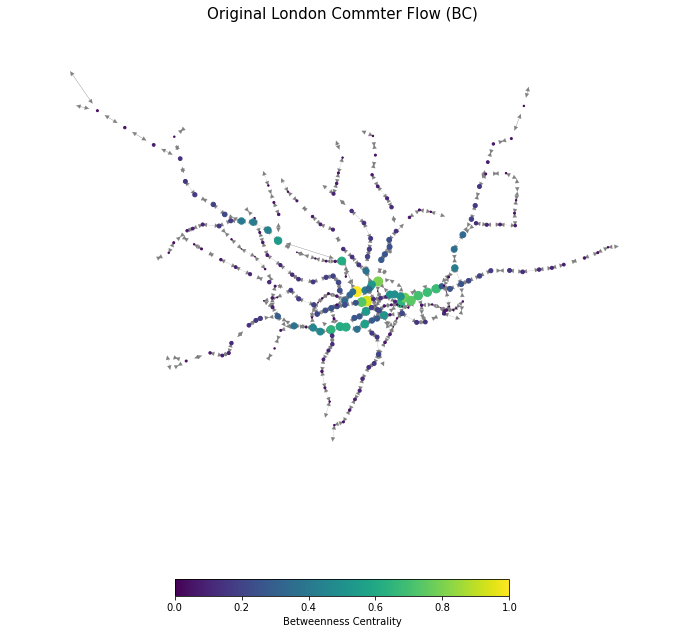

<Figure size 432x288 with 0 Axes>

In [34]:
# 1. Plot directed original graph by node
betweenness_w_values=[(i[1]['betweenness_flows']) for i in g_flows.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_flows']/max(betweenness_w_values)) for i in g_flows.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_flows']/max(betweenness_w_values)*100) for i in g_flows.nodes(data=True)]

pos={e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(g_flows, pos,edge_color='gray', width=0.2)

nod=nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.axis("off")
plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Original London Commter Flow (BC)",fontsize=15)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('p2_BC1.png', dpi=100)

In [35]:
# 2. on edges
bet_london_e=nx.edge_betweenness_centrality(g_flows, normalized=True, weight='v_weights')
nx.set_edge_attributes(g_flows,bet_london_e,'betweenness_edge')

In [36]:
# top 10 commuter edges 
BC=pd.DataFrame.from_dict(dict(bet_london_e.items()),columns=['betweenness_edge'],orient='index')
e_maxbet10=BC.sort_values(by=['betweenness_edge'],ascending=False)[:10]
e_maxbet10 = e_maxbet10.index.tolist()
for i in e_maxbet10:
    print(g_flows.edges[i]['station_names'])

('Liverpool Street', 'Aldgate East')
('Aldgate East', 'Whitechapel')
('Aldgate East', 'Liverpool Street')
('Whitechapel', 'Stepney Green')
('Stepney Green', 'Mile End')
('Whitechapel', 'Aldgate East')
('Stepney Green', 'Whitechapel')
('Mile End', 'Stepney Green')
('Bond Street', 'Oxford Circus')
('Oxford Circus', 'Bond Street')


In [37]:
list(g_flows.edges(data = True))[0:3]

[(0,
  1,
  {'weight': 96682.0,
   'station_names': ('Baker Street', 'Marylebone'),
   'v_weights': 1e-05,
   'betweenness_edge': 0.053809064609450334}),
 (0,
  2,
  {'weight': 1560.0,
   'station_names': ('Baker Street', "Regent's Park"),
   'v_weights': 0.00064,
   'betweenness_edge': 0.0}),
 (0,
  33,
  {'weight': 126001.0,
   'station_names': ('Baker Street', 'Bond Street'),
   'v_weights': 1e-05,
   'betweenness_edge': 0.08057894924818737})]

### network intro

In [38]:
print(nx.info(g_flows))

Name: 
Type: DiGraph
Number of nodes: 306
Number of edges: 651
Average in degree:   2.1275
Average out degree:   2.1275


### Sequential removal

In [41]:
nodes=[]
for i in range (10):
    a = nx.get_node_attributes(g_flows,'betweenness_flows')
    for n in g_flows:
        if a[n] == max(bet_london_w.values()):
            print(g_flows.nodes[n]['station'])
            nodes.append(n)
            g_flows.remove_node(n)
            bet_london_w=nx.betweenness_centrality(g_flows, weight='v_weights', normalized=False)
            nx.set_node_attributes(g_flows,bet_london_w,'betweenness_flows')
            break
print(nodes)

Baker Street
Earl's Court
Oxford Circus
Notting Hill Gate
Bank
King's Cross St. Pancras
Embankment
West Ham
London Bridge
Ealing Common
[0, 116, 24, 60, 25, 88, 4, 109, 154, 115]


In [42]:
print(nx.info(g_flows))

Name: 
Type: DiGraph
Number of nodes: 296
Number of edges: 552
Average in degree:   1.8649
Average out degree:   1.8649


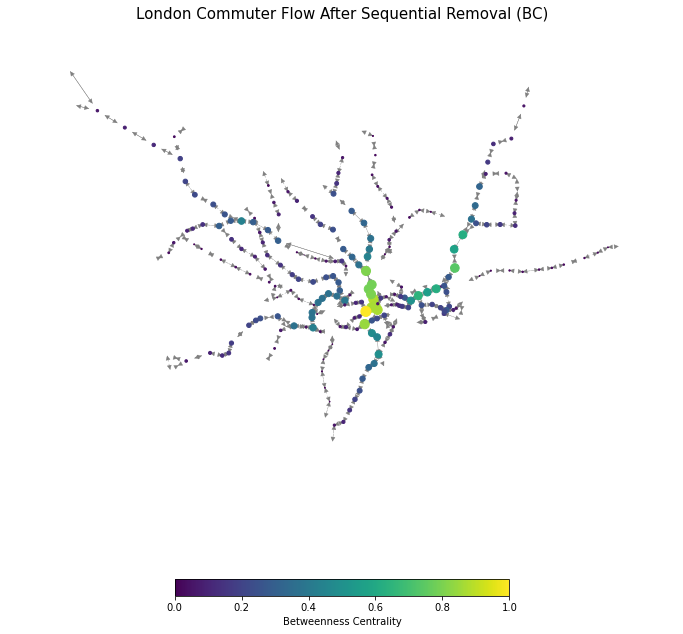

<Figure size 432x288 with 0 Axes>

In [55]:
# after removal plot
betweenness_w_values=[(i[1]['betweenness_flows']) for i in g_flows.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_flows']/max(betweenness_w_values)) for i in g_flows.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_flows']/max(betweenness_w_values)*100) for i in g_flows.nodes(data=True)]

pos={e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(g_flows, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.axis("off")
plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.title("London Commuter Flow After Sequential Removal (BC)",fontsize=15)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('p2_BC2.png', dpi=100)

### Analysis

In [44]:
# 1. all connected components 
components = [len(c) for c in sorted(nx.strongly_connected_components(g_flows), key=len, reverse=True)]
len(components) # there are 38 strong components in the network

38

In [46]:
# 2. strongest component:
strong_component = max(nx.strongly_connected_components(g_flows), key=len)
G = g_flows.subgraph(strong_component)

In [47]:
print(nx.info(G))  # the largest connected component has only 68 nodes remaining left

Name: 
Type: DiGraph
Number of nodes: 68
Number of edges: 148
Average in degree:   2.1765
Average out degree:   2.1765


In [48]:
# 3. unweighted diameter
nx.diameter(G)

30

In [54]:
# 4. weighted (distance) diameter
nlen = {n:nx.single_source_dijkstra_path_length(G, n, weight='v_weights') 
        for n in G.nodes() }
e = nx.eccentricity(G,sp=nlen)
d = nx.diameter(G, e)
d

0.0014400000000000003

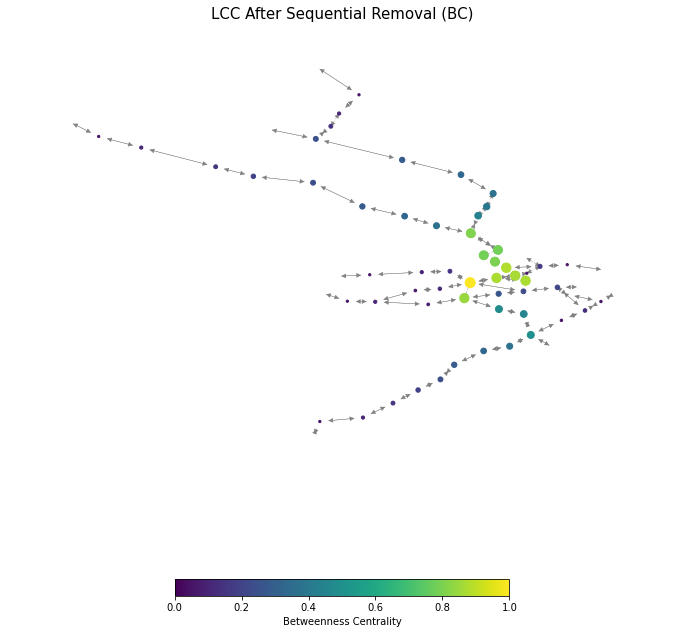

<Figure size 432x288 with 0 Axes>

In [56]:
# largest component plot
betweenness_w_values=[(i[1]['betweenness_flows']) for i in G.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_flows']/max(betweenness_w_values)) for i in G.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_flows']/max(betweenness_w_values)*100) for i in G.nodes(data=True)]

pos={e1: xy for e1,xy in G.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in G.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.axis("off")
plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("LCC After Sequential Removal (BC)",fontsize=15)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('p2_BC3.png', dpi=100)